# GW150914 with MCMC Infinity



In [1]:
import bilby
import mcmc_infinity as mc
import corner
import matplotlib.pyplot as plt
import jax
import numpy as np

import os
os.environ["OMP_NUM_THREADS"] = "1"

seed = 1234

# Initial samples

In [2]:
result = bilby.core.result.read_in_result("outdir/GW150914_dynesty_result.json")
parameters = [
    "chirp_mass",
    "mass_ratio",
    "chi_1",
    "chi_2",
    "ra",
    "dec",
    "theta_jn",
    "psi",
    "geocent_time",
]
# Extract the initial samples from the result
initial_samples = result.posterior[parameters].to_numpy()
geocent_idx = parameters.index("geocent_time")
geocent_min = initial_samples[:, geocent_idx].min()
initial_samples[:, geocent_idx] = initial_samples[:, geocent_idx] - geocent_min

# Proposal

First, we train the normalizing flow using the initial samples

 28%|██▊       | 138/500 [00:26<01:09,  5.24it/s, train=0.69, val=2.02 (Max patience reached)]


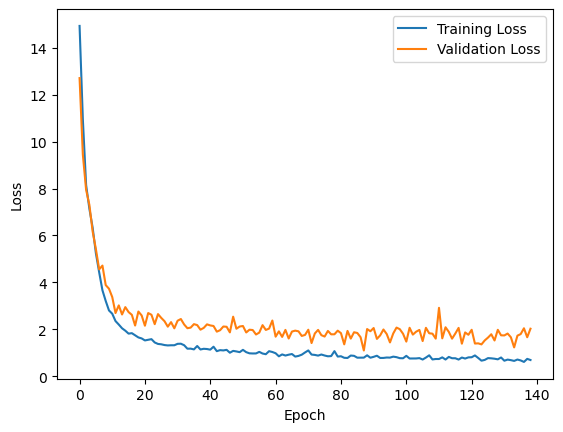

In [3]:
dim = len(parameters)
bounds = []
for p in parameters:
    bounds.append(np.array([result.priors[p].minimum, result.priors[p].maximum]))

bounds[geocent_idx] = bounds[geocent_idx] - geocent_min

flow_key, fit_key, samples_key = jax.random.split(jax.random.key(seed), 3)
proposal = mc.normalizing_flow_proposal.NormalizingFlowProposal(
   dim, bounds=bounds, key=flow_key, flow_layers=6, nn_width=32, nn_depth=3,
)

init_key = jax.random.key(seed + 10)

losses = proposal.fit(
    initial_samples,
    key=fit_key,
    max_epochs=500,
    batch_size=100,
    max_patience=50,
    learning_rate=0.001,
)

fig = plt.figure()
plt.plot(losses['train'], label='Training Loss')
plt.plot(losses['val'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


Plot the samples from the flow compared to the initial samples

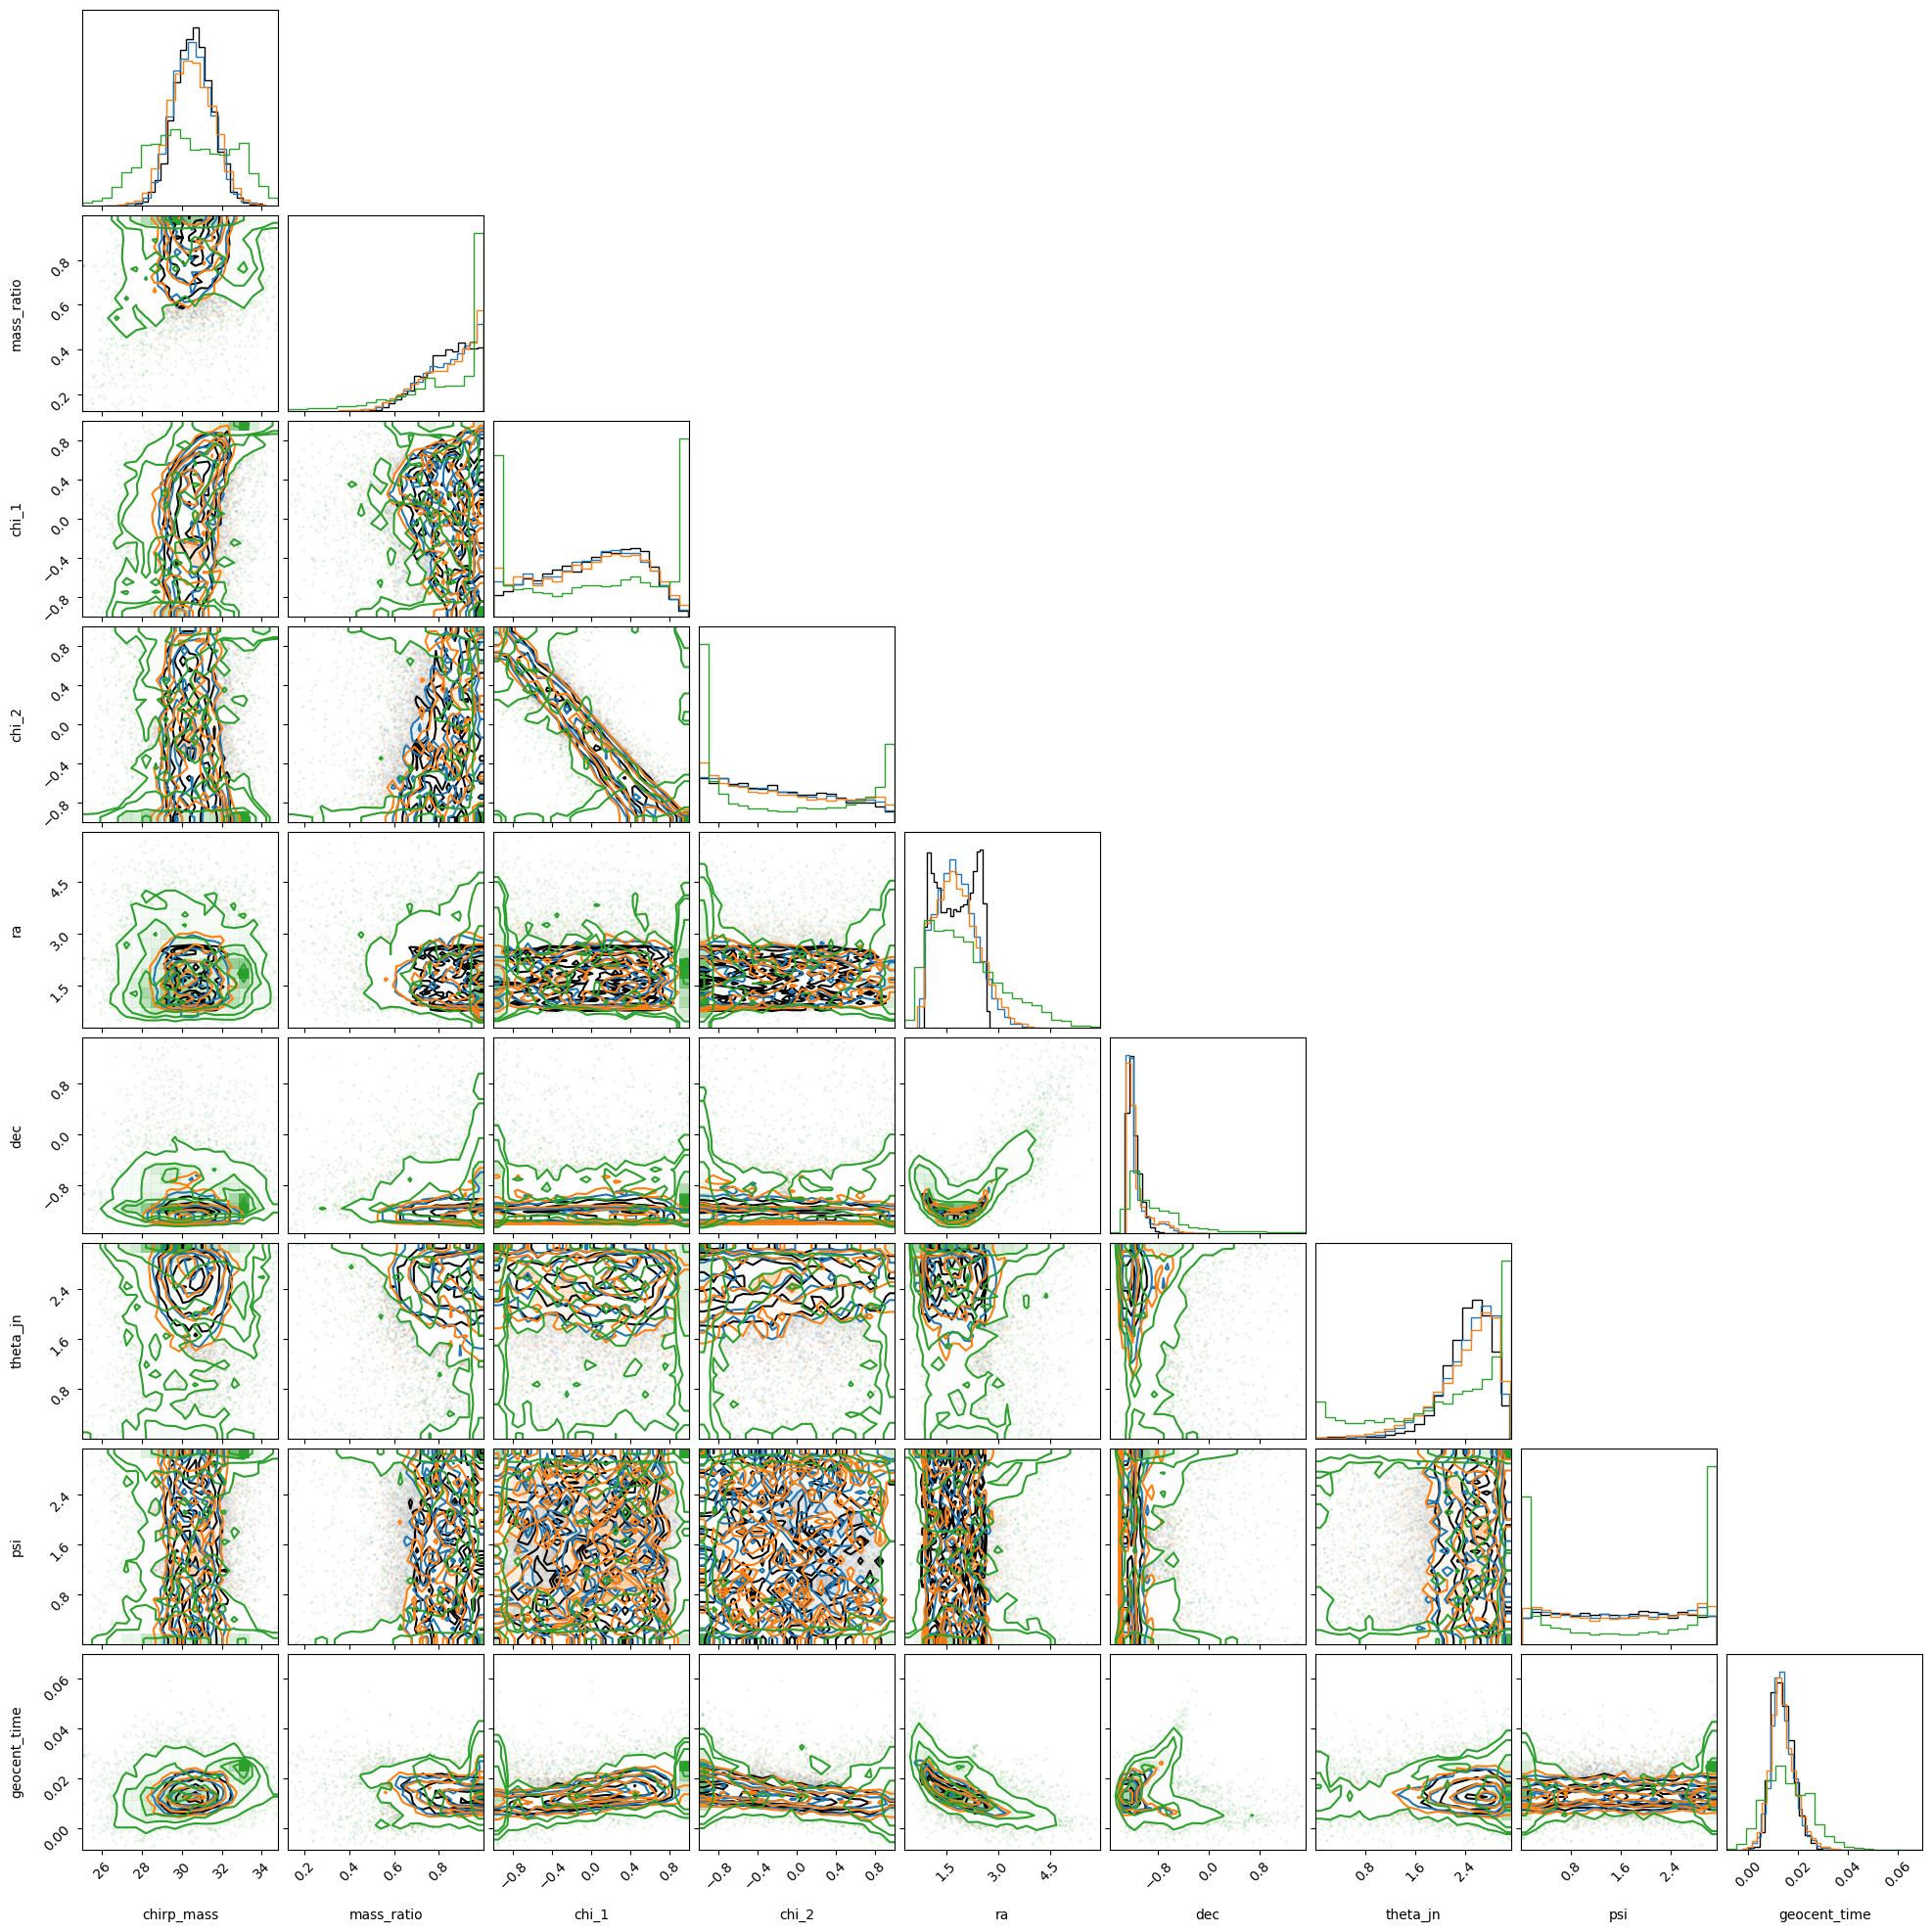

In [4]:

fig = corner.corner(
    initial_samples,
    density=True,
    hist_kwargs={"density": True, "color": "k"},
)

for i, sigma in enumerate([1, 1.1, 2.5]):
    proposal.set_flow_annealing(sigma)
    flow_samples = proposal.sample(samples_key, num_samples=5000)

    fig = corner.corner(
        np.array(flow_samples),
        labels=parameters,
        fig=fig,
        density=True,
        color=f"C{i}",
        hist_kwargs={"density": True, "color": f"C{i}"},
    )
# Reset the flow annealing to 1.0
proposal.set_flow_annealing(1.0)

In [5]:
from run_GW150914 import likelihood, priors

likelihood.parameters
theta = priors.sample()
likelihood.parameters.update(theta)
likelihood.log_likelihood()

/home/michael/.conda/envs/perfect-mcmc/lib/python3.11/site-packages/gwpy/time/__init__.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  from lal import LIGOTimeGPS
10:56 bilby INFO    : Downloading analysis data for ifo H1
10:56 bilby INFO    : Downloading psd data for ifo H1
10:57 bilby INFO    : Downloading analysis data for ifo L1
10:57 bilby INFO    : Downloading psd data for ifo L1
10:58 bilby INFO    : Saving data plots to outdir
10:58 bilby INFO    : Waveform ge

-5244.403384538282

In [ ]:
class BilbyTarget:

    def __init__(self, likelihood, priors, parameters):
        self.likelihood = likelihood
        self.priors = priors
        self.dim = len(parameters)
        self.parameters = parameters

    def logP(self, x):
        theta = {k: v for k, v in zip(self.parameters, x)}
        theta["geocent_time"] += geocent_min
        log_prior = self.priors.ln_prob(theta)
        if not np.isfinite(log_prior):
            return -np.inf
        self.likelihood.parameters.update(theta)
        log_likelihood = self.likelihood.log_likelihood()
        return log_prior + log_likelihood

    def __call__(self, *args, **kwds):
        return self.logP(*args, **kwds)

In [7]:
target = BilbyTarget(likelihood, priors, parameters)

Check the target is working

In [8]:
x = proposal.sample(jax.random.key(seed + 20))
target(x)

np.float64(-4965.66974859983)

Get the initial sample, for now we use the maximum log-likelihood from the posterior

In [11]:
proposal.set_flow_annealing(1.1)
flow_samples = proposal.sample(samples_key, num_samples=1000)
log_prob = np.fromiter(map(target, flow_samples), float)
log_q = proposal(flow_samples)
log_ratio = log_prob - log_q

In [12]:
def func(x):
    return target(x) - proposal(x)


from scipy.optimize import minimize

min_result = minimize(
    func,
    initial_samples[np.argmax(result.posterior["log_likelihood"].values)],
    method="Nelder-Mead",
)
print("Minimum found at:", min_result.x)

XLAL Error - XLALSimIMRPhenomDGenerateFD (/home/conda/feedstock_root/build_artifacts/lalsimulation-split_1747993095335/work/lib/LALSimIMRPhenomD.c:141): Spins outside the range [-1,1] are not supported

XLAL Error - XLALSimIMRPhenomDGenerateFD (/home/conda/feedstock_root/build_artifacts/lalsimulation-split_1747993095335/work/lib/LALSimIMRPhenomD.c:141): Input domain error
XLAL Error - XLALSimInspiralChooseFDWaveform_legacy (/home/conda/feedstock_root/build_artifacts/lalsimulation-split_1747993095335/work/lib/LALSimInspiralGeneratorLegacy.c:1633): Internal function call failed: Input domain error


RuntimeError: Internal function call failed: Input domain error

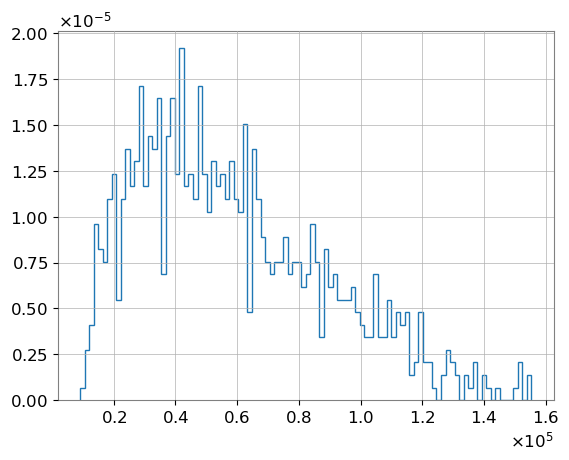

In [12]:
plt.figure()
plt.hist(log_ratio, bins=100, density=True, histtype='step')
plt.show()

In [13]:

x0 = [initial_samples[np.argmax(result.posterior["log_likelihood"].values)]]
proposal.set_flow_annealing(1.1)
sampler = mc.sampler.PerfectSampler(target, proposal, x0, seed=seed)

In [ ]:
test_sample, t_test = sampler.get_perfect_sample(2, verbose=True, return_T=True)

Trying T=2 steps...


: 

In [ ]:

T, num_samples = 2, 50

samples, t_vals = sampler.get_perfect_samples(T, num_samples, verbose=False)

  0%|          | 0/100 [00:00<?, ?it/s]/home/michael/.conda/envs/perfect-mcmc/lib/python3.11/site-packages/jax/_src/ops/scatter.py:93: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float64 to dtype=int32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(
 96%|█████████▌| 96/100 [02:35<00:01,  2.01it/s]

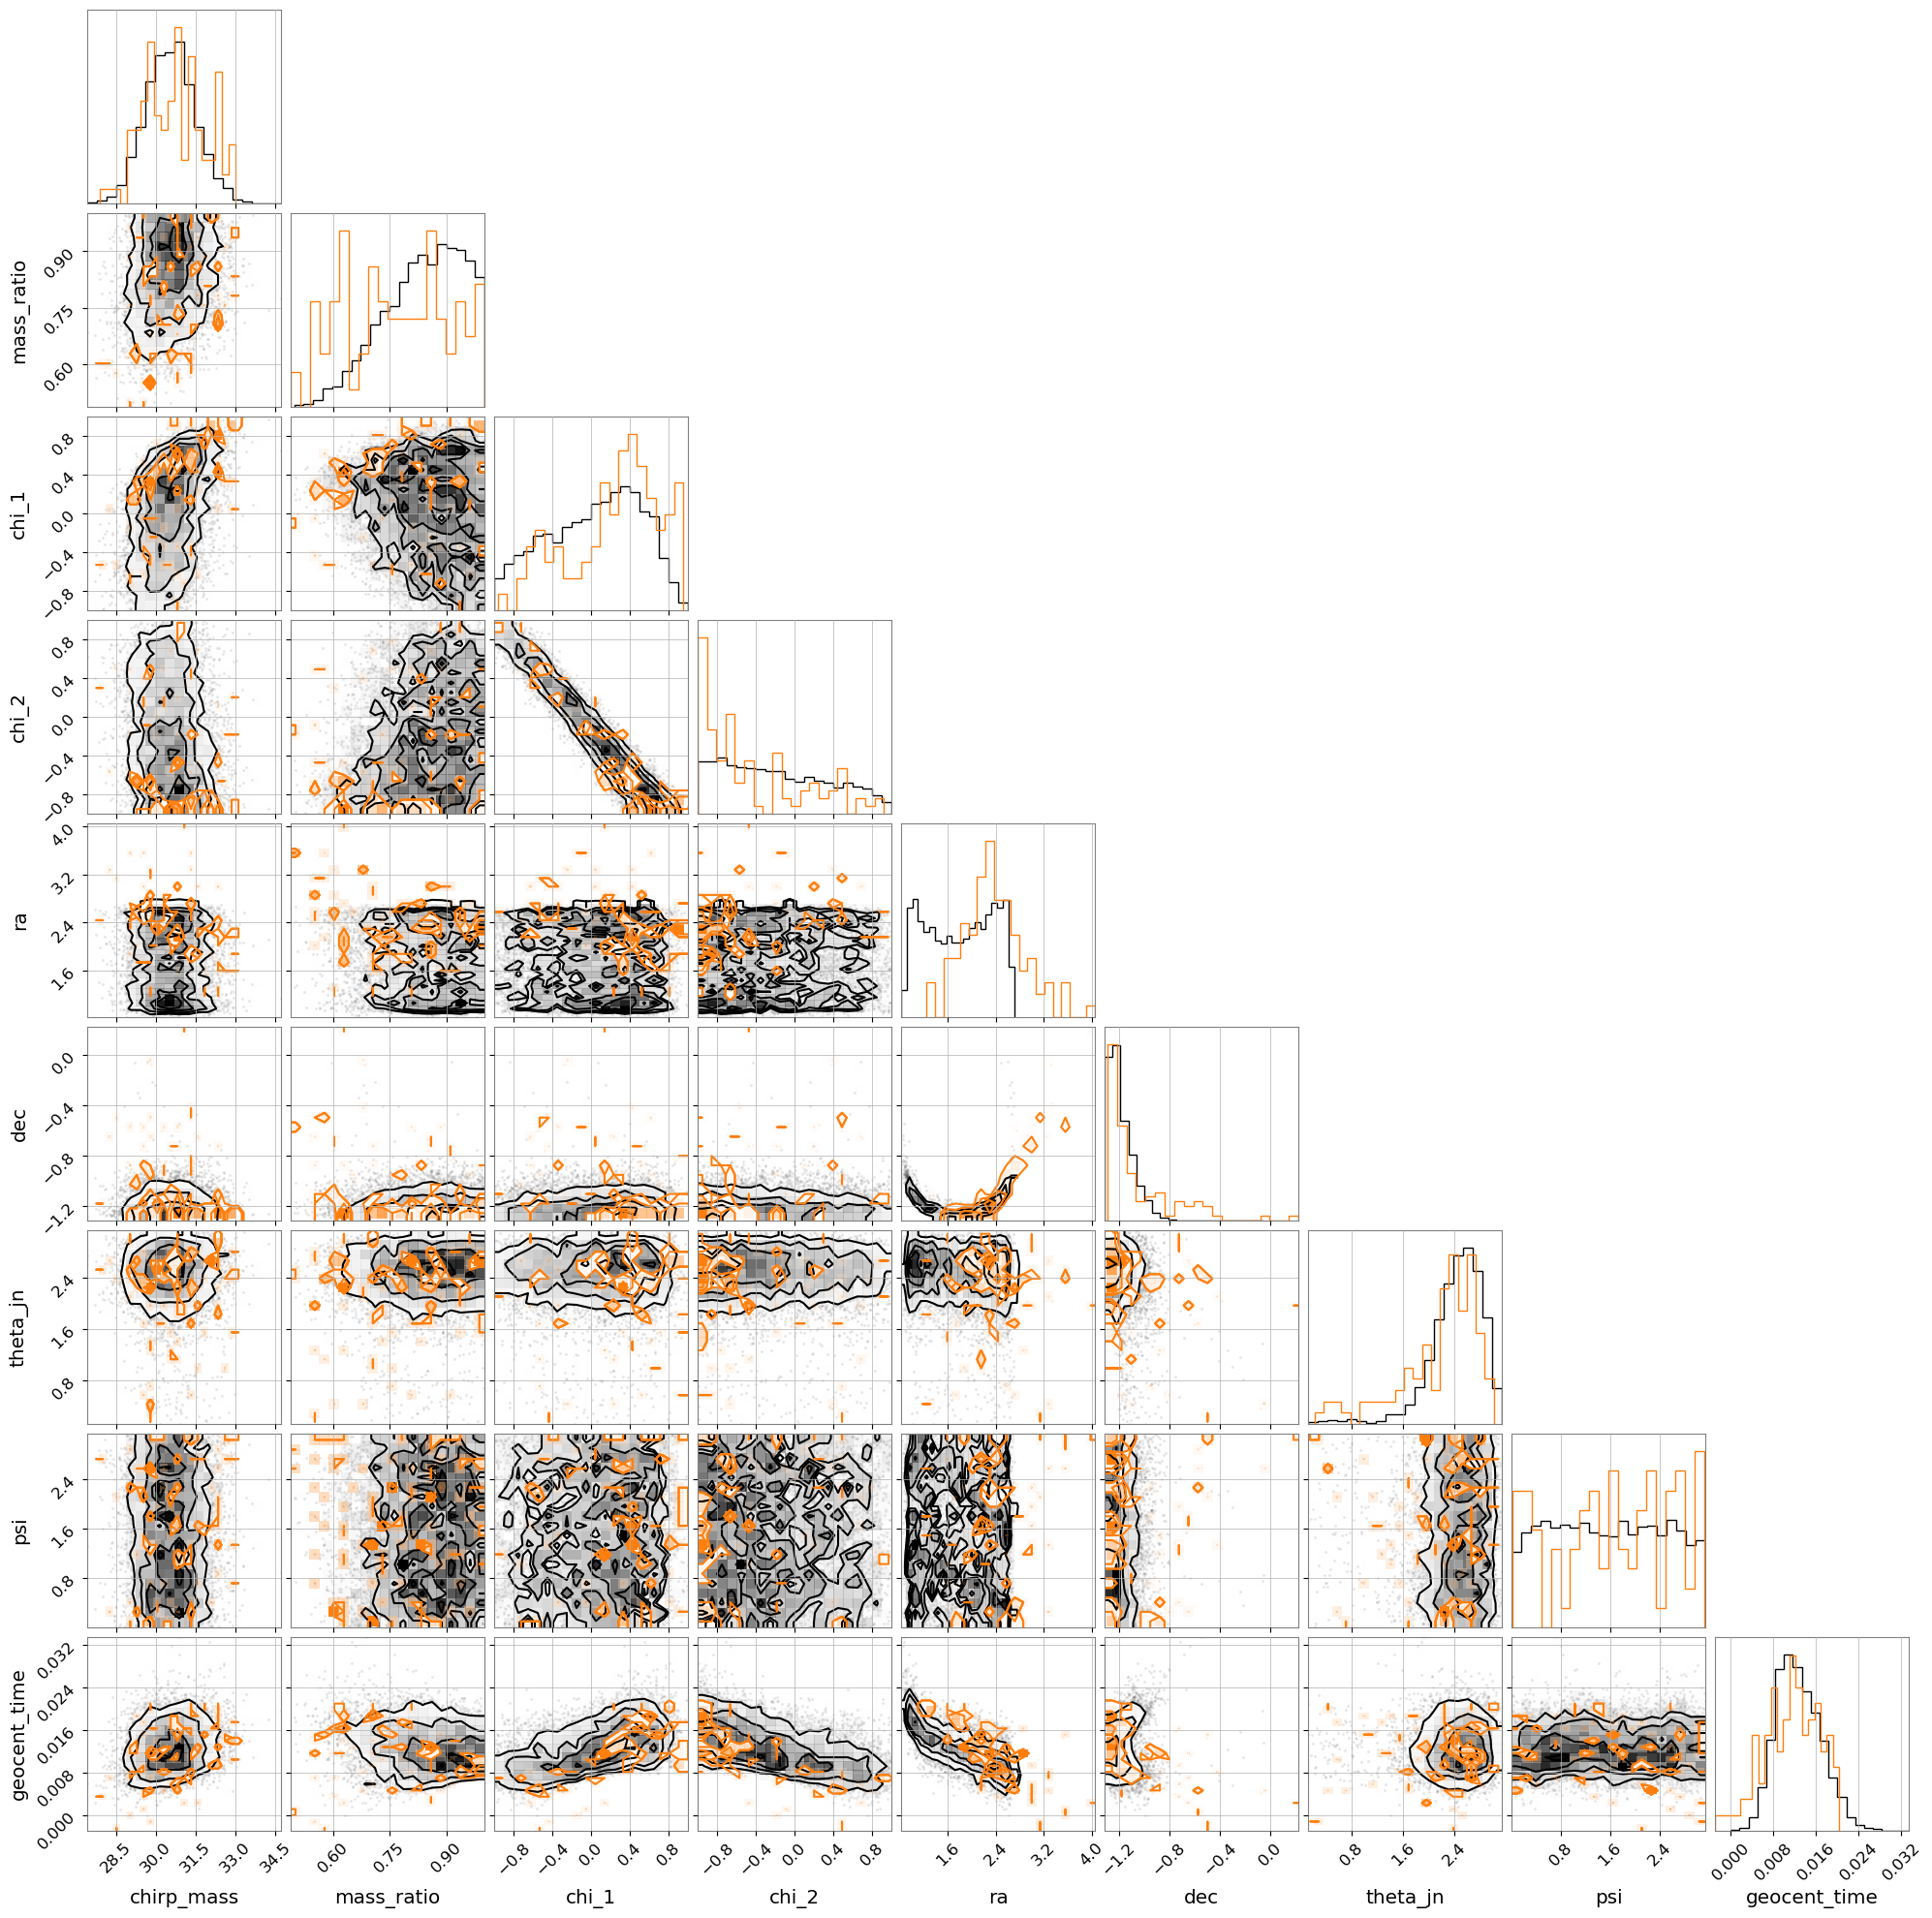

In [ ]:
fig = corner.corner(
    initial_samples,
    density=True,
    hist_kwargs={"density": True, "color": "k"},
)

fig = corner.corner(
    np.array(samples),
    plot_contour=False,
    plot_datapoints=True,
    labels=parameters,
    density=True,
    color="C1",
    hist_kwargs={"density": True, "color": "C1"},
    fig=fig,
)

# fig.savefig("GW150914_samples_initial.png", dpi=300)